In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [2]:
game_df = pd.read_csv('game.csv')
game_info_df = pd.read_csv('game_info.csv')
team_df = pd.read_csv('team.csv')
team_details_df = pd.read_csv('team_details.csv')

In [3]:
team_details_df.drop(['headcoach', 'twitter', 'instagram', 'facebook', 'yearfounded'], axis=1, inplace=True)

In [4]:
merged_df = pd.merge(game_df, game_info_df, on='game_id')
# Group the dataframe by 'team_id'
grouped = merged_df.groupby(['team_id_home'])
merged_df['game_date_x'] = pd.to_datetime(merged_df['game_date_x'])

# Calculate the time differences in days for the 'game_date_x' column
time_diff = grouped['game_date_x'].diff().dt.days
merged_df['days_off_home'] = time_diff.fillna(0)

# Group the dataframe by 'team_id'
grouped = merged_df.groupby(['team_id_away'])
merged_df['game_date_x'] = pd.to_datetime(merged_df['game_date_x'])

# Calculate the time differences in days for the 'game_date_x' column
time_diff = grouped['game_date_x'].diff().dt.days
merged_df['days_off_away'] = time_diff.fillna(0)

In [5]:
merged_df = pd.merge(merged_df, team_details_df, left_on='team_id_home', right_on='team_id')
merged_df['attend_density'] = merged_df['attendance'] / merged_df['arenacapacity']

In [6]:
merged_df.drop(merged_df[merged_df['attend_density'] > 1].index, inplace=True)
# merged_df.drop(merged_df[merged_df['attend_density'] == 0].index, inplace=True)

In [7]:
merged_df = merged_df[merged_df['season_id'] >= 22002]
merged_df = merged_df[['days_off_home', 'days_off_away', 'attend_density', 'game_id']]

In [8]:
import datetime
game_merge_data = pd.read_csv('game_merged_data.csv')
game_merge_data = pd.merge(game_info_df, game_merge_data, on='game_id', how='left')
game_merge_data.drop('game_date_y', axis=1, inplace=True)
game_merge_data.rename(columns={'game_date_x': 'game_date'}, inplace=True)
game_merge_data = game_merge_data[game_merge_data['season_id'] >= 22001]
game_merge_data.drop('id_home', axis=1, inplace=True)
game_merge_data.drop('id_away', axis=1, inplace=True)
game_merge_data = game_merge_data.merge(team_details_df.add_suffix('_home'), left_on='team_id_home', right_on='team_id_home', suffixes=('', '_home'))
game_merge_data = game_merge_data.merge(team_details_df.add_suffix('_away'), left_on='team_id_away', right_on='team_id_away', suffixes=('', '_away'))
game_merge_data['season_id'] = game_merge_data['season_id'].astype(int)

# add is_covid column, from 3/1/2020 - 10/11/2020
game_merge_data['is_covid'] = 0
start_date = datetime.datetime(2020, 3, 1, 0, 0)
end_date = datetime.datetime(2020, 10, 11, 0, 0)
game_merge_data['game_date'] = pd.to_datetime(game_merge_data['game_date'])
game_merge_data.loc[(game_merge_data['game_date'] >= start_date) & (game_merge_data['game_date'] <= end_date), 'is_covid'] = 1
# game_merge_data.loc[(game_merge_data['game_date'] >= start_date) & (game_merge_data['game_date'] <= end_date), 'attendance'] = 0


# 使用 str.replace 方法将列名中的 "_home_home" 替换成 "_home"
game_merge_data.columns = game_merge_data.columns.str.replace('_home_home', '_home')

# 使用 str.replace 方法将列名中的 "_away_away" 替换成 "_home"
game_merge_data.columns = game_merge_data.columns.str.replace('_away_away', '_away')

# 使用 drop 方法删除重复列名
game_merge_data = game_merge_data.loc[:, ~game_merge_data.columns.duplicated()]

game_merge_data.drop(game_merge_data.filter(regex='Unnamed').columns, axis=1, inplace=True)
game_merge_data = merged_df.merge(game_merge_data, on='game_id')
game_merge_data.drop('distance_y', axis=1, inplace=True)
game_merge_data.rename(columns={'distance_x': 'distance'}, inplace=True)
game_merge_data.head()

,days_off_home,days_off_away,attend_density,game_id,game_date,attendance,game_time,season_id,team_id_home,team_abbreviation_home,...,arenacapacity_home,owner_home,generalmanager_home,dleagueaffiliation_home,arena_away,arenacapacity_away,owner_away,generalmanager_away,dleagueaffiliation_away,is_covid
0,196.0,196.0,1.00000,20200004,2002-10-30,18624.0,2:12,22002,1.610613e+09,BOS,...,18624,Wyc Grousbeck,Brad Stevens,Maine Celtics,United Center,21711,Jerry Reinsdorf,Arturas Karnisovas,Windy City Bulls,0
1,8.0,2.0,1.00000,20200069,2002-11-07,18624.0,2:37,22002,1.610613e+09,BOS,...,18624,Wyc Grousbeck,Brad Stevens,Maine Celtics,Crypto.com Arena,19060,Jerry Buss Family Trust,Rob Pelinka,South Bay Lakers,0
2,4.0,8.0,0.83736,20200095,2002-11-11,15595.0,2:13,22002,1.610613e+09,BOS,...,18624,Wyc Grousbeck,Brad Stevens,Maine Celtics,Vivint Arena,20000,Ryan Smith,Justin Zanik,Salt Lake City Stars,0
3,2.0,4.0,0.89782,20200107,2002-11-13,16721.0,2:09,22002,1.610613e+09,BOS,...,18624,Wyc Grousbeck,Brad Stevens,Maine Celtics,Wells Fargo Center,21000,Joshua Harris,Elton Brand,Delaware Blue Coats,0
4,2.0,2.0,1.00000,20200119,2002-11-15,18624.0,2:09,22002,1.610613e+09,BOS,...,18624,Wyc Grousbeck,Brad Stevens,Maine Celtics,American Airlines Center,19200,Mark Cuban,Nico Harrison,Texas Legends,0


In [9]:
final_merged_data = game_merge_data.copy()

In [10]:
# final_merged_data = pd.merge(game_team_home, team_merged_data, left_on='team_id_away', right_on='team_id', suffixes=('_home', '_away'))
final_merged_data['home_advantage'] = (final_merged_data['wl_home'] == 'W').astype(int)

In [11]:
def convert_distance(distance_str):
    distance, unit = distance_str.split()
    distance = float(distance.replace(',', ''))
    if unit == 'km':
        return distance * 0.621371192
    if unit == 'ft':
        return distance * 0.000189393939
    return distance

final_merged_data['distance_mi'] = final_merged_data['distance'].apply(convert_distance)
final_merged_data['distance_mi'] = final_merged_data['distance_mi'].astype(int)

In [12]:
# 计算attendance team和attendance league
# # 计算每个赛季每个主场球队的平均出勤率
# stadium_season_avg_attendance = final_merged_data.groupby(['season_id', 'team_id_home'])['attendance'].mean().reset_index()
# stadium_season_avg_attendance.columns = ['season_id', 'team_id_home', 'stadium_season_avg']

# # 计算每个赛季的联盟平均出勤率
# league_season_avg_attendance = final_merged_data.groupby('season_id')['attendance'].mean().reset_index()
# league_season_avg_attendance.columns = ['season_id', 'league_season_avg']

# # 将计算出的平均值与原始数据集合并
# final_merged_data = final_merged_data.merge(stadium_season_avg_attendance, on=['season_id', 'team_id_home'])
# final_merged_data = final_merged_data.merge(league_season_avg_attendance, on='season_id')

# # 创建新列
# final_merged_data['attendance_team'] = final_merged_data['attendance'] / final_merged_data['stadium_season_avg']
# final_merged_data['attendance_league'] = final_merged_data['attendance'] / final_merged_data['league_season_avg']

# selected_columns = [
#     'days_off_home', 'days_off_away', 'attend_density', 'game_id', 'game_date', 'attendance',
#     'season_id', 'team_id_home', 'team_id_away', 'team_abbreviation_home', 'team_abbreviation_away',
#     'team_name_home', 'team_name_away', 'wl_home', 'pts_home', 'pts_away', 'time_diff', 'distance_mi',
#     'attendance_team', 'attendance_league', 'is_covid'
# ]

# fit_dataset = final_merged_data[selected_columns]
# fit_dataset.head()


In [13]:
home_wins = final_merged_data[final_merged_data['wl_home'] == 'W'].shape[0]
home_losses = final_merged_data[final_merged_data['wl_home'] == 'L'].shape[0]

away_wins = final_merged_data[final_merged_data['wl_away'] == 'W'].shape[0]
away_losses = final_merged_data[final_merged_data['wl_away'] == 'L'].shape[0]

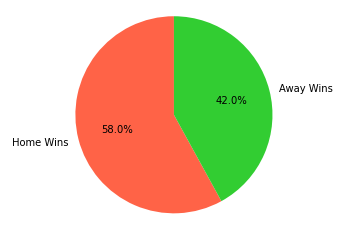

In [14]:
# Pie chart data
labels = ['Home Wins', 'Away Wins']
# sizes = [home_wins, home_losses, away_wins, away_losses]
sizes = [home_wins, away_wins]
# colors = ['#FF6347', '#1E90FF', '#32CD32', '#FFD700']
colors = ['#FF6347', '#32CD32']
# Plot pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Display the pie chart
plt.show()

In [15]:
season_group = final_merged_data.groupby('season_id')
win_rate_per_season = season_group['wl_home'].apply(lambda x: (x == 'W').sum() / x.count())

# index_range = pd.Index(range(22001, 22024))  # 包含22001到22023的范围
# win_rate_per_season = win_rate_per_season.reindex(index_range, fill_value=0)

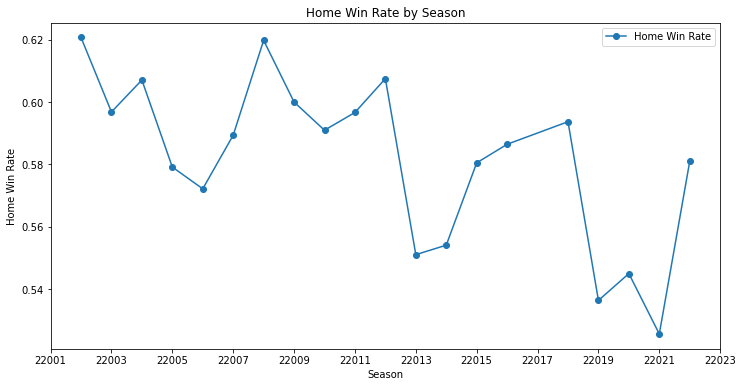

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot a line chart
ax.plot(win_rate_per_season.index, win_rate_per_season, marker='o', linestyle='-', label='Home Win Rate')

# Plot an area chart (uncomment the following line to use an area chart)
# ax.fill_between(win_rate_per_season.index, win_rate_per_season, color='skyblue', alpha=0.5, label='Home Win Rate')

# Customize the chart
ax.set_xlabel('Season')
ax.set_ylabel('Home Win Rate')
ax.set_title('Home Win Rate by Season')
ax.legend()

ax.set_xlim(22001, 22023)
ax.set_xticks(np.arange(22001, 22024, step=2))

# Display the chart
plt.show()

In [17]:
# calculate win # of each team
home_wins = final_merged_data[final_merged_data['wl_home'] == 'W'].groupby('team_id_home')['wl_home'].count().reset_index()
home_wins.columns = ['team_id', 'home_wins']

# calculate home match for each number
home_games = final_merged_data.groupby('team_id_home')['wl_home'].count().reset_index()
home_games.columns = ['team_id', 'home_games']

# home advantege calculated
home_advantage = pd.merge(home_wins, home_games, on='team_id')
home_advantage['home_win_rate'] = home_advantage['home_wins'] / home_advantage['home_games']

# merge 
team_home_advantage = pd.merge(team_df, home_advantage, left_on='id', right_on='team_id')

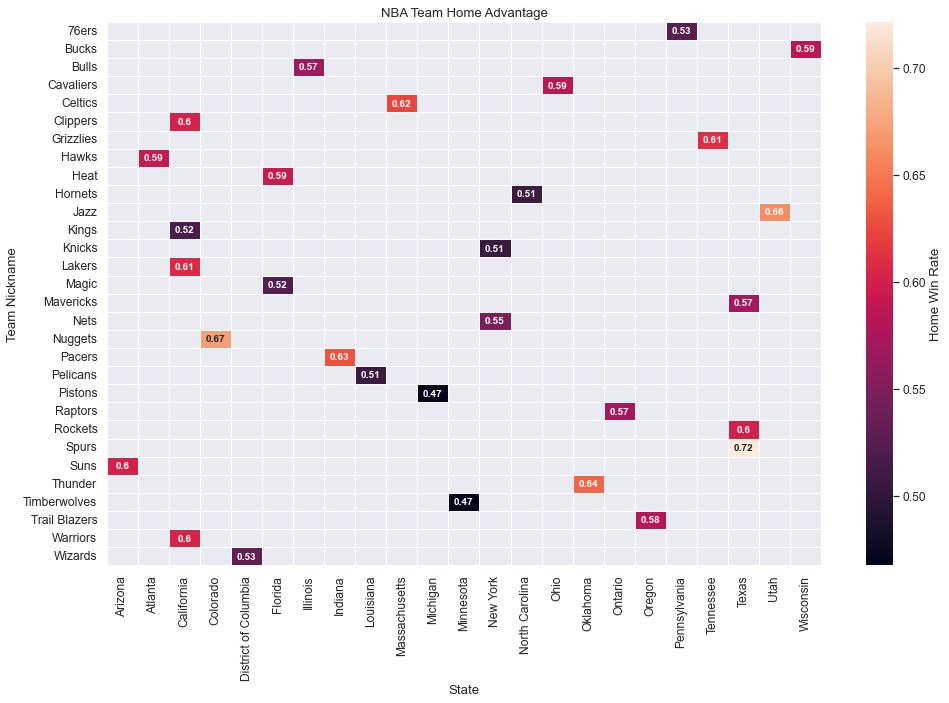

In [18]:
# Prepare the data for the heatmap
team_home_advantage_pivot = team_home_advantage.pivot(
    index="nickname",
    columns="state",
    values="home_win_rate"
)

# Create the heatmap
plt.figure(figsize=(16, 10))
sns.set(font_scale=1.1)  # Adjust font size
heatmap = sns.heatmap(
    team_home_advantage_pivot,
    annot=True,
    linewidths=0.5,
    cbar_kws={"label": "Home Win Rate"},
    annot_kws={"fontsize": 10, "fontweight": "bold"}
)

# Add gridlines
heatmap.set_xticks([x + 0.5 for x in range(len(team_home_advantage_pivot.columns))], minor=True)
heatmap.set_yticks([y + 0.5 for y in range(len(team_home_advantage_pivot.index))], minor=True)
heatmap.xaxis.set_ticks_position('none') 
heatmap.yaxis.set_ticks_position('none') 
heatmap.grid(which='minor', color='black', linewidth=1)

plt.title("NBA Team Home Advantage")
plt.xlabel("State")
plt.ylabel("Team Nickname")
plt.show()

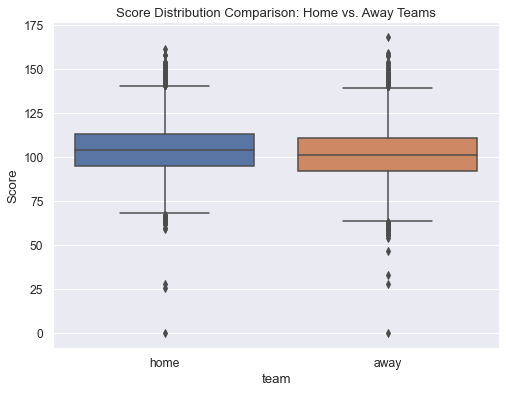

In [19]:
score_data = pd.DataFrame({
    "team": ["home"] * len(final_merged_data) + ["away"] * len(final_merged_data),
    "score": final_merged_data["pts_home"].tolist() + final_merged_data["pts_away"].tolist()
})

plt.figure(figsize=(8, 6))
sns.boxplot(x="team", y="score", data=score_data)
plt.title("Score Distribution Comparison: Home vs. Away Teams")
plt.ylabel("Score")
plt.show()

In [20]:
# # Create a copy of the dataframe to avoid modifying the original dataframe
encoded_data = final_merged_data.copy()

# Initialize the OrdinalEncoder
encoder = OrdinalEncoder()

# Fit and transform the selected columns
encoded_columns = encoder.fit_transform(encoded_data[['timezone']])

# Assign the encoded columns back to the dataframe
encoded_data[['timezone']] = encoded_columns

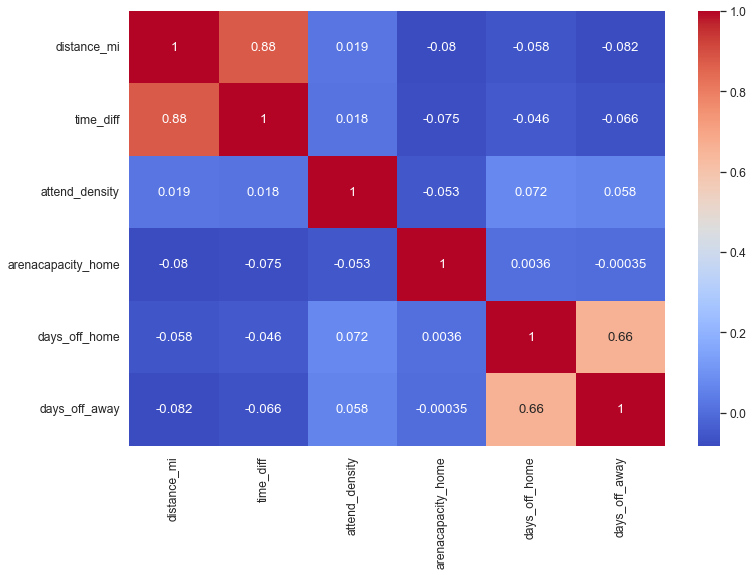

In [21]:
scaler = MinMaxScaler()
columns_to_normalize = ['distance_mi', 'time_diff', 'attend_density', 'arenacapacity_home', 'days_off_home', 'days_off_away']
encoded_data[columns_to_normalize] = scaler.fit_transform(encoded_data[columns_to_normalize])
factors = encoded_data[columns_to_normalize]
correlations = factors.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.show()

Text(0.5, 1.0, 'Home Advantage vs. Attendance date')

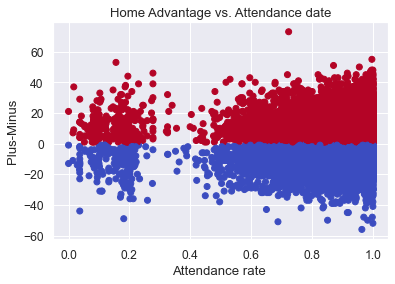

In [22]:
plt.scatter(final_merged_data['attend_density'], final_merged_data['plus_minus_home'], c=final_merged_data['home_advantage'], cmap='coolwarm')

# set axis labels and title
plt.xlabel('Attendance rate ')
plt.ylabel('Plus-Minus')
plt.title('Home Advantage vs. Attendance date')

In [23]:
features = ['arenacapacity_away', 'arenacapacity_home', 'attend_density', 'time_diff', 'distance_mi']

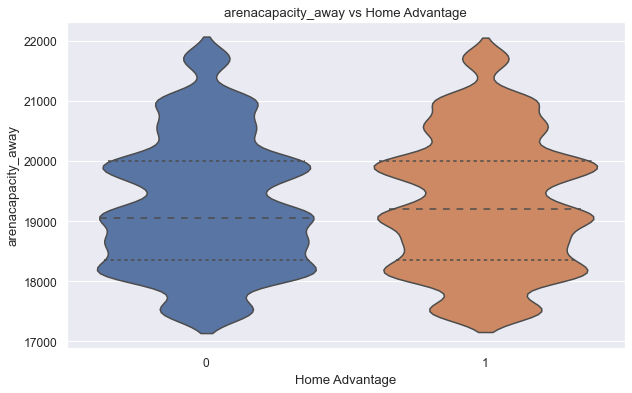

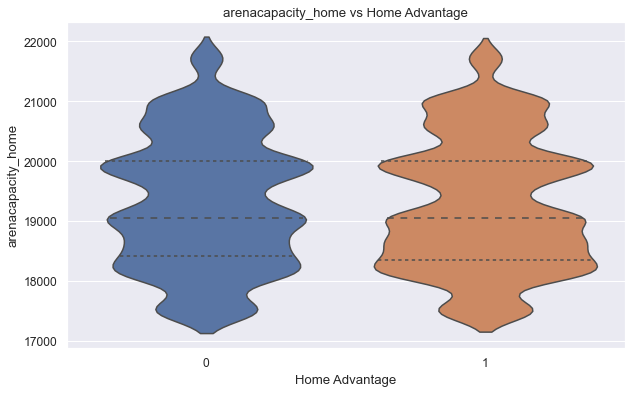

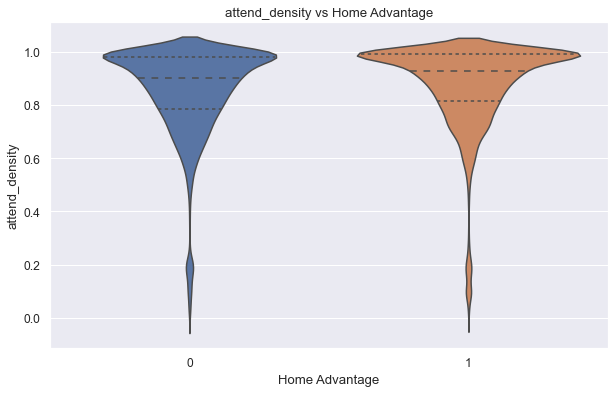

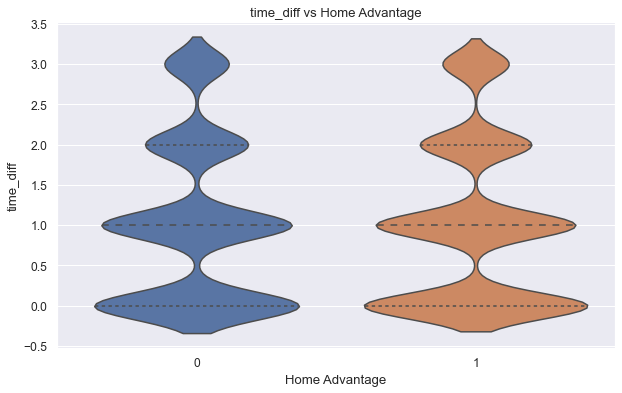

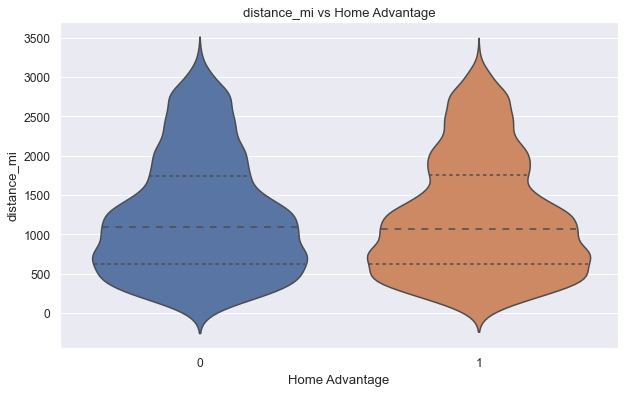

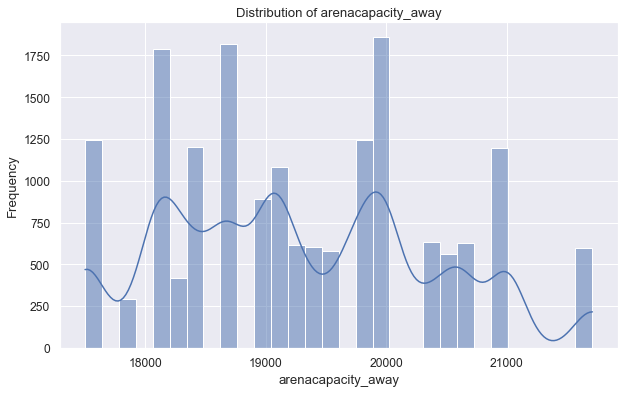

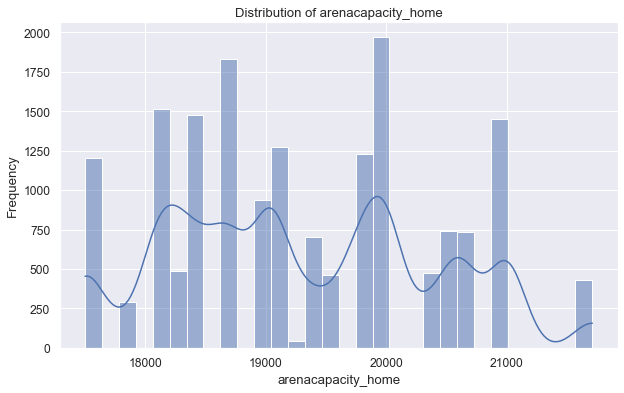

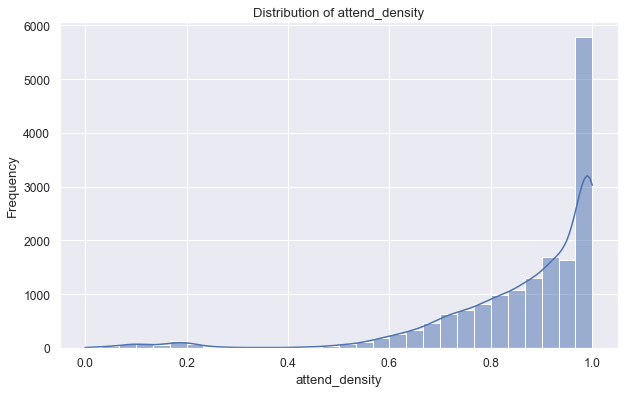

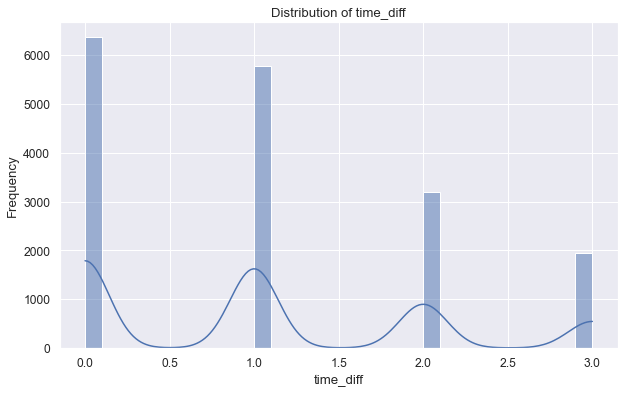

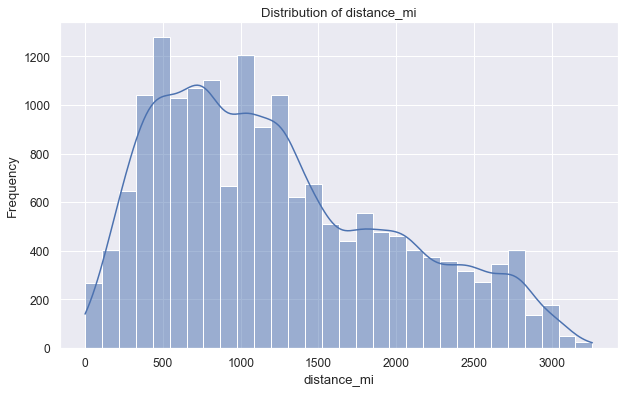

In [24]:
# 创建针对每个特征的箱型图
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='home_advantage', y=feature, data=final_merged_data, inner='quartile')
    plt.title(f'{feature} vs Home Advantage')
    plt.xlabel('Home Advantage')
    plt.ylabel(feature)
    plt.show()

# 创建针对每个特征的直方图
for feature in features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=final_merged_data, x=feature, kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()